In [ ]:
!pip install yfinance streamlit tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
import yfinance as yf
from datetime import date
import math
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import requests
from bs4 import BeautifulSoup


In [ ]:
start = '2010-01-01'
today = '2022-01-01'

df = yf.download('AAPL', start , today)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# df

In [ ]:
user_input = 'AAPL'
url = f'https://finance.yahoo.com/quote/{user_input}?p={user_input}&.tsrc=fin-srch'
response = requests.get(url)
print(response.status_code)

200


In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')
beta = soup.find('td', {'data-test': 'BETA_5Y-value'}).text

In [ ]:
df = df.reset_index()['Close']

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
training_size = math.floor(int(len(df)*0.70))
test_size = len(df) - training_size
train_data, test_data = df[0:training_size,:],df[training_size:len(df),:1]

In [ ]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(x_test.shape), print(y_test.shape)

(806, 100)
(806,)


(None, None)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional

model2 = Sequential()

model2.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(100,1))))
model2.add(Dropout(0.3))

model2.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model2.add(Dropout(0.4))

model2.add(Bidirectional(LSTM(units=50)))
model2.add(Dropout(0.5))

model2.add(Dense(units=1))

model2.build(input_shape=(None, 100, 1)) 

model2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 100, 100)         20800     
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 100, 100)          0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 100, 100)         60400     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 100, 100)          0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 100)              60400     
 onal)                                                           
                                                      

In [ ]:
model2.compile(optimizer = 'adam', loss='mean_squared_error')
model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
32/32 [==============================] - 44s 779ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 2/100
32/32 [==============================] - 14s 439ms/step - loss: 3.5112e-04 - val_loss: 0.0079
Epoch 3/100
32/32 [==============================] - 14s 443ms/step - loss: 2.9120e-04 - val_loss: 0.0051
Epoch 4/100
32/32 [==============================] - 16s 496ms/step - loss: 2.3546e-04 - val_loss: 0.0028
Epoch 5/100
32/32 [==============================] - 16s 510ms/step - loss: 2.2438e-04 - val_loss: 0.0014
Epoch 6/100
32/32 [==============================] - 14s 439ms/step - loss: 1.9550e-04 - val_loss: 0.0013
Epoch 7/100
32/32 [==============================] - 14s 442ms/step - loss: 1.8478e-04 - val_loss: 0.0028
Epoch 8/100
32/32 [==============================] - 14s 440ms/step - loss: 2.2192e-04 - val_loss: 9.2679e-04
Epoch 9/100
32/32 [==============================] - 14s 444ms/step - loss: 1.8499e-04 - val_loss: 0.0011
Epoch 10/100
32/32 [==========================

In [ ]:
model2.save('bidirectional_lstm_model.h5')
from keras.models import load_model
model2= load_model('bidirectional_lstm_model.h5')

In [ ]:
train_predict = model2.predict(x_train)
test_predict = model2.predict(x_test)

26/26 [==============================] - 3s 108ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
from sklearn.metrics import mean_squared_error
# math.sqrt(mean_squared_error(y_train, train_predict))

In [ ]:
# math.sqrt(mean_squared_error(y_test, test_predict))

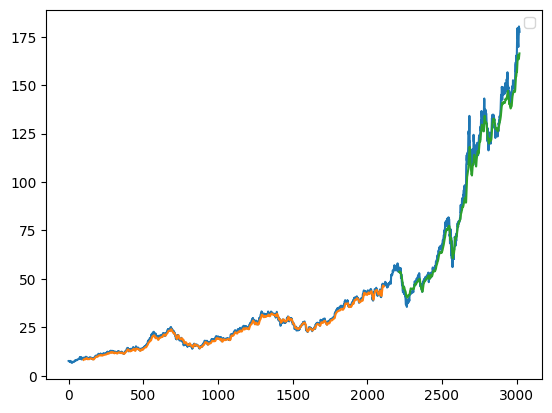

In [ ]:
look_back = 100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()


In [ ]:
len(test_data)

907

In [ ]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
from numpy import array

lst_output=[]
n_steps=100
i=0
year = 1//12
days = 60
while(i<days):
    
    if(len(temp_input)>100):
        # print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model2.predict(x_input)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model2.predict(x_input)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

1/1 [==============================] - 0s 48ms/step
[[0.9211975932121277], [0.9108216762542725], [0.8991992473602295], [0.8872672319412231], [0.8754981756210327], [0.8643969297409058], [0.8542883396148682], [0.845051109790802], [0.8366701602935791], [0.8291592001914978], [0.8225846886634827], [0.8169506788253784], [0.8121467232704163], [0.807976245880127], [0.8041958212852478], [0.8009989261627197], [0.7981876134872437], [0.795654833316803], [0.7933564782142639], [0.7911821603775024], [0.789317786693573], [0.7877401113510132], [0.7866206169128418], [0.7856625914573669], [0.7849469780921936], [0.7843548059463501], [0.7839494347572327], [0.7838369011878967], [0.7839822173118591], [0.7841495275497437], [0.7842135429382324], [0.7842391133308411], [0.7842828631401062], [0.7844452857971191], [0.7848188877105713], [0.7852030992507935], [0.7857239842414856], [0.7862876653671265], [0.7871190905570984], [0.7879536151885986], [0.7888659834861755], [0.7898690700531006], [0.7910774946212769], [0.79

In [ ]:
y_test1 = []
past_100_days_testing = test_data[-100:]
temp = past_100_days_testing.reshape(1, 100, 1)
a = 100
days = 0

while days<60:
  if a == 100:
    y_predicted1 = model2.predict(temp)
    # print('100')
    # value = y_predicted1[0][0]
    # print(value)
    y_test1.append([y_predicted1[0][0]])
    temp = np.append(temp, [y_predicted1], axis=1)
    days = days+1
    a = 101
  else:
    # print('101')
    temp = np.delete(temp, 0, axis=1)
    a = 100
    

y_test1 = np.array(y_test1)
print(y_test1)

1/1 [==============================] - 0s 45ms/step
[[0.9211976 ]
 [0.9108217 ]
 [0.89919925]
 [0.88726723]
 [0.8754982 ]
 [0.8643969 ]
 [0.85428834]
 [0.8450511 ]
 [0.83667016]
 [0.8291592 ]
 [0.8225847 ]
 [0.8169507 ]
 [0.8121467 ]
 [0.80797625]
 [0.8041958 ]
 [0.8009989 ]
 [0.7981876 ]
 [0.79565483]
 [0.7933565 ]
 [0.79118216]
 [0.7893178 ]
 [0.7877401 ]
 [0.7866206 ]
 [0.7856626 ]
 [0.784947  ]
 [0.7843548 ]
 [0.78394943]
 [0.7838369 ]
 [0.7839822 ]
 [0.7841495 ]
 [0.78421354]
 [0.7842391 ]
 [0.78428286]
 [0.7844453 ]
 [0.7848189 ]
 [0.7852031 ]
 [0.785724  ]
 [0.78628767]
 [0.7871191 ]
 [0.7879536 ]
 [0.788866  ]
 [0.78986907]
 [0.7910775 ]
 [0.79250073]
 [0.7941988 ]
 [0.7961065 ]
 [0.798032  ]
 [0.8000339 ]
 [0.80205256]
 [0.80405146]
 [0.8061053 ]
 [0.80821866]
 [0.8104235 ]
 [0.8126567 ]
 [0.81486005]
 [0.8170581 ]
 [0.8190518 ]
 [0.8211483 ]
 [0.82322454]
 [0.8251776 ]]


In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,days+101)

In [ ]:
# df[len(df)-100:]

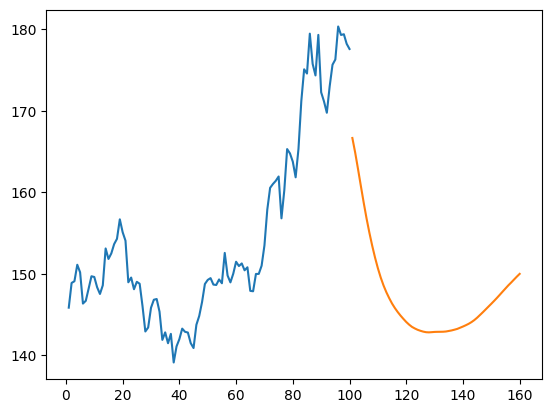

In [ ]:
plt.plot(day_new, scaler.inverse_transform(df[len(df)-100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

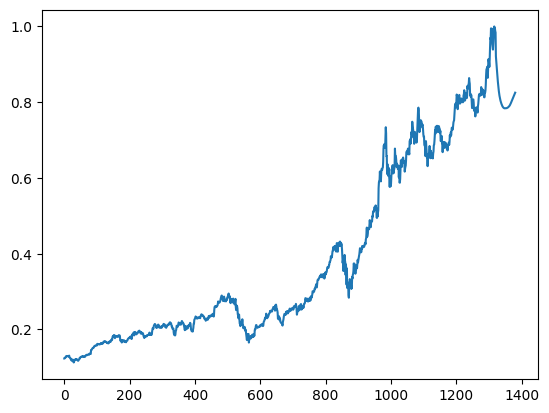

In [ ]:
df1=df.tolist()
df1.extend(lst_output)
plt.plot(df1[1700:])

In [ ]:
df1=scaler.inverse_transform(df1).tolist()

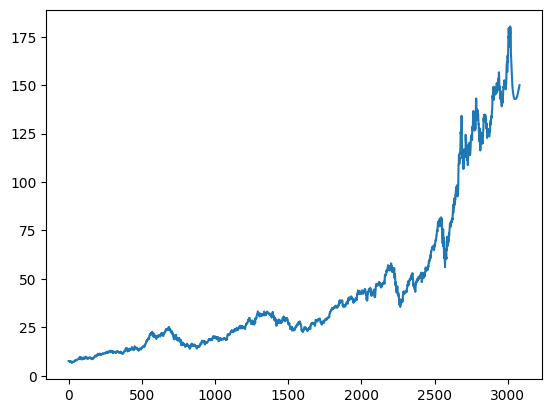

In [ ]:
plt.plot(df1)

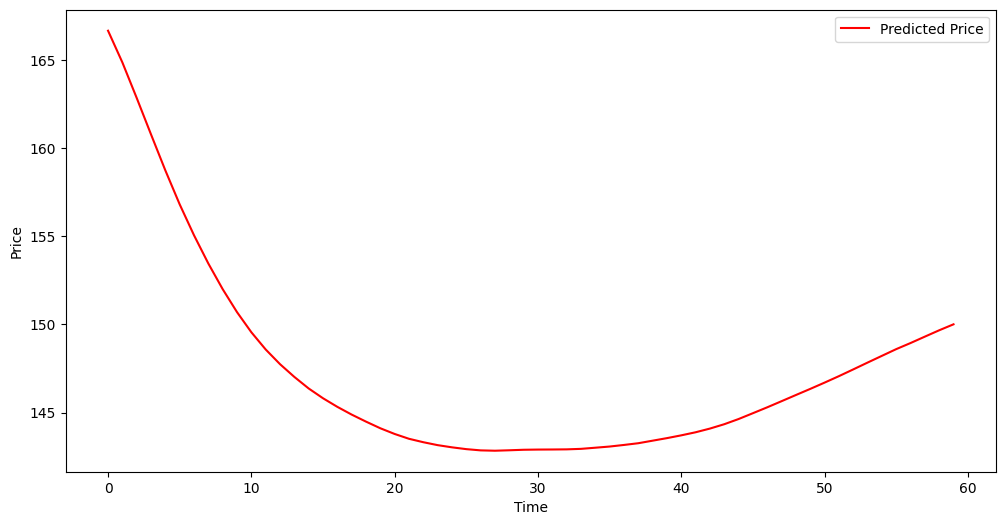

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# plot y_test and y_predicted on the first y-axis
ax1.plot(scaler.inverse_transform(y_test1), 'r', label='Predicted Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.tick_params(axis='y')
ax1.legend()


# ax1.axvline(x=len(y_predicted)-0.5, color='black', linestyle='dashed')
# ax1.axvline(x=len(y_predicted)+0.5, color='black', linestyle='dashed')

plt.show()


In [ ]:
%%writefile app_LSTMFuture.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
import yfinance as yf
from datetime import date
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import streamlit as st
from numpy import array
from bs4 import BeautifulSoup
import requests

st.title('Stock Trend Prediction')
start = '2010-01-01'
today = date.today().strftime("%Y-%m-%d")

user_input = st.text_input("Enter Stock Ticker", 'AAPL')
df = yf.download(user_input, start , today)

url = f'https://finance.yahoo.com/quote/{user_input}?p={user_input}&.tsrc=fin-srch'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
beta = soup.find('td', {'data-test': 'BETA_5Y-value'}).text

st.subheader("Beta value/ Risk")
st.write(beta)

st.subheader("Data Overview")
st.write(df.describe())
df = df.reset_index()['Close']

scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)


training_size = math.floor(int(len(df)*0.70))
test_size = len(df) - training_size
train_data, test_data = df[0:training_size,:],df[training_size:len(df),:1]

time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

st.subheader('Closing Prive vs Time chart')
fig = plt.figure(figsize = (12,6))
plt.plot(scaler.inverse_transform(df))
st.pyplot(fig)

model2 = load_model('bidirectional_lstm_model.h5')

train_predict = model2.predict(x_train)
test_predict = model2.predict(x_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

look_back = 100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

st.subheader('Closing Price vs Time chart showing predictions for training and testing data')
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(len(df)), scaler.inverse_transform(df), label='Actual')
ax.plot(range(len(df)), trainPredictPlot, label='Training Predictions')
ax.plot(range(len(df)), testPredictPlot, label='Testing Predictions')
ax.legend()
fig.suptitle('Closing Price vs Time')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
fig.autofmt_xdate()
st.pyplot(fig)

x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
days = st.number_input("Enter number of days: ", 30)
while(i<days):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model2.predict(x_input)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model2.predict(x_input)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

day_new = np.arange(1, 101)
day_pred = np.arange(101, days + 101)

st.subheader('Closing Prive vs Time chart showing future predictions')
fig3, ax = plt.subplots(figsize=(12, 6))
ax.plot(day_new, scaler.inverse_transform(df[len(df)-100:]))
ax.plot(day_pred, scaler.inverse_transform(lst_output)) 
ax.set_xlabel('Time')
ax.set_ylabel('Closing Price')
ax.legend(['Actual Price', 'Predicted Price'])
st.pyplot(fig3)


Overwriting app_LSTMFuture.py


In [ ]:
!streamlit run app_LSTMFuture.py & npx localtunnel --port 8501

[#######...........] / extract:localtunnel: verb lock using /root/.npm/_locks/s


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.136.241.113:8501

npx: installed 22 in 4.155s
your url is: https://short-beans-shine-34-136-241-113.loca.lt
2023-04-26 22:20:16.688796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 41ms/step
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 43ms/step
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 42ms/step
